# Capstone: Sprint 2: Extended EDA
Yael Brown \
November 14, 2024 

In [22]:
# Load libraries
import numpy as np
import pandas as pd
import warnings
import time

from datetime import datetime

In [3]:
# Suppress warnings in the notebook
warnings.filterwarnings("ignore")

In [4]:
# Load Libraries 
heist_df = pd.read_csv('../data/btc_HeistData.csv')

In [5]:
heist_df.shape

(2916697, 10)

In [6]:
# Reduce size for development
size = 50000

heist_df = heist_df.iloc[:size]

In [7]:
heist_df.columns

Index(['address', 'year', 'day', 'length', 'weight', 'count', 'looped',
       'neighbors', 'income', 'label'],
      dtype='object')

In [8]:
heist_df.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000.0,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,71200000.0,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,princetonLocky


In [9]:
# drop label, neighbors, looped, count, weight, length
heist_df.drop(columns=['label', 'neighbors', 'looped', 'count', 'weight', 'length'], axis=1, inplace=True)

heist_df.head()

,address,year,day,income
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,100050000.0
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,100000000.0
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,200000000.0
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,71200000.0
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,200000000.0


In [ ]:
# Convert day to month and day
df = heist_df # This made it easier to develop this process and I can switch from temp dataframe to heist_df and not worry about messing up the code

# Rename column
df.rename(columns={'day': 'day_of_year'}, inplace=True)

# Verify rename
print(df.info())

# Instantiate day and month columns that we need
df['day'] = 0
df['month'] = 0

# Add month and day (calculate it from day_of_year
# (I couldn't get df.apply() to work and reassign both columns at once) 
length = len(df)

cnt = 0
for r in range(0, length):
    print(cnt)
    row = df.iloc[r]
    date = pd.to_datetime(row['day_of_year'], format='%j', errors='coerce') + pd.DateOffset(years=row['year'] - 1970)
    row['month'] = date.month
    row['day'] = date.day
    df.iloc[r] = row
    cnt += 1

# Drop day_of_year column
df.drop(columns=['day_of_year'], axis=1, inplace=True)

# Assign back to heist_df
heist_df = df

# Clean up memory
del df

In [11]:
# Verify month and day are present. 
heist_df.head()

,address,year,income,day,month
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,100050000.0,11,1
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,100000000.0,12,5
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,200000000.0,3,9
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,71200000.0,18,11
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,200000000.0,26,8


## Import cleaned (and sampled dataset) btc transaction dataset
Here we have to import the cleaned dataset to match the sender or reciever addresses with the known heist addresses in our dataset and mark them as possible fraudulent transactions. The problem with this is that we are using a extremely small proportion of the transaction dataset and that may not be enough to have flag as possible fraud and train our model. 

The model will be trained on (target variables) address and the amount that is transferred. 

In [58]:
btc_processed_df = pd.read_csv("../data/btc_trans_data/data_raw/btc_data_cleaned.csv")

btc_processed_df.head()

,timestamp,source_address,destination_address,satoshi,year,month,day
0,1451606601,1CVu8VTq7iakNBffmgJssBbN1Kje4Wz6XF,3Qe6Zfj7Dm3fa96HXp5u8GjDARAt2MHM9V,1.000000e+09,2016,1,1
1,1451606601,1CVu8VTq7iakNBffmgJssBbN1Kje4Wz6XF,1RCgvJmbRWq77GzT5TK4mxzyzSBtHmeod,9.480760e+09,2016,1,1
2,1451606601,17evnw2mbKyPB1WuFhGcYznrxJAwi1WrHx,3Qe6Zfj7Dm3fa96HXp5u8GjDARAt2MHM9V,1.000000e+09,2016,1,1
3,1451606601,17evnw2mbKyPB1WuFhGcYznrxJAwi1WrHx,1RCgvJmbRWq77GzT5TK4mxzyzSBtHmeod,9.480760e+09,2016,1,1
4,1451606601,17evnw2mbKyPB1WuFhGcYznrxJAwi1WrHx,3Qe6Zfj7Dm3fa96HXp5u8GjDARAt2MHM9V,1.000000e+09,2016,1,1


In [60]:
# Convert year, month, day to intenters
columns = ["year", "month", "day"]

btc_processed_df[columns] = btc_processed_df[columns].astype(int)

btc_processed_df.head()

,timestamp,source_address,destination_address,satoshi,year,month,day
0,1451606601,1CVu8VTq7iakNBffmgJssBbN1Kje4Wz6XF,3Qe6Zfj7Dm3fa96HXp5u8GjDARAt2MHM9V,1.000000e+09,2016,1,1
1,1451606601,1CVu8VTq7iakNBffmgJssBbN1Kje4Wz6XF,1RCgvJmbRWq77GzT5TK4mxzyzSBtHmeod,9.480760e+09,2016,1,1
2,1451606601,17evnw2mbKyPB1WuFhGcYznrxJAwi1WrHx,3Qe6Zfj7Dm3fa96HXp5u8GjDARAt2MHM9V,1.000000e+09,2016,1,1
3,1451606601,17evnw2mbKyPB1WuFhGcYznrxJAwi1WrHx,1RCgvJmbRWq77GzT5TK4mxzyzSBtHmeod,9.480760e+09,2016,1,1
4,1451606601,17evnw2mbKyPB1WuFhGcYznrxJAwi1WrHx,3Qe6Zfj7Dm3fa96HXp5u8GjDARAt2MHM9V,1.000000e+09,2016,1,1


In [62]:
btc_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12070 entries, 0 to 12069
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            12070 non-null  int64  
 1   source_address       12070 non-null  object 
 2   destination_address  12070 non-null  object 
 3   satoshi              12070 non-null  float64
 4   year                 12070 non-null  int32  
 5   month                12070 non-null  int32  
 6   day                  12070 non-null  int32  
dtypes: float64(1), int32(3), int64(1), object(2)
memory usage: 518.8+ KB


In [64]:
# Create possible fraud col
btc_processed_df["isPossibleFraud"] = 0

btc_processed_df["isPossibleFraud"].head()

0    0
1    0
2    0
3    0
4    0
Name: isPossibleFraud, dtype: int64

In [66]:
btc_processed_df['year'].value_counts()

year
2016    12070
Name: count, dtype: int64

In [84]:
# Check for matches
btc_processed_df['combined'] = btc_processed_df['source_address'] + '_' + btc_processed_df['destination_address']

matched = btc_processed_df['combined'].isin(heist_df['address'])

matched.value_counts()

combined
False    12070
Name: count, dtype: int64

In [80]:
btc_processed_df['combined']

0        1CVu8VTq7iakNBffmgJssBbN1Kje4Wz6XF_3Qe6Zfj7Dm3...
1        1CVu8VTq7iakNBffmgJssBbN1Kje4Wz6XF_1RCgvJmbRWq...
2        17evnw2mbKyPB1WuFhGcYznrxJAwi1WrHx_3Qe6Zfj7Dm3...
3        17evnw2mbKyPB1WuFhGcYznrxJAwi1WrHx_1RCgvJmbRWq...
4        17evnw2mbKyPB1WuFhGcYznrxJAwi1WrHx_3Qe6Zfj7Dm3...
                               ...                        
12065    1LGwghZ82b61ef3SLDuh5F2jywRhDiS246_1MK1YdGSEUP...
12066    1LGwghZ82b61ef3SLDuh5F2jywRhDiS246_1DGcwcKVxo9...
12067    1KC1zxvPXeFGqBxHnBbcN7F56qbQ1KSeKT_1P6kYQTjH7R...
12068    1KC1zxvPXeFGqBxHnBbcN7F56qbQ1KSeKT_1KC1zxvPXeF...
12069    1KC1zxvPXeFGqBxHnBbcN7F56qbQ1KSeKT_16AXyXxzNPg...
Name: combined, Length: 12070, dtype: object

In [100]:
# See what years are in dataset
print(heist_df['year'].value_counts(), "\n")
print(heist_df.shape)

year
2016    15631
2014    10319
2011     8652
2013     7494
2015     3701
2017     3486
2012      714
2018        3
Name: count, dtype: int64 

(50000, 5)


In [102]:
# Only extract the year 2016
heist_df = heist_df[heist_df['year'] == 2016]

heist_df.shape

(15631, 5)

<Axes: xlabel='month'>

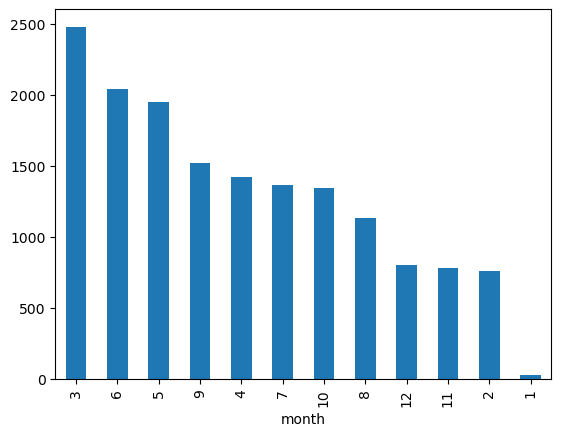

In [143]:
# Check heist df. 
heist_df['month'].value_counts().plot(kind='bar')

In [138]:
btc_processed_df['month'].value_counts()

month
1    12070
Name: count, dtype: int64

More values in heist df are in March. I will have to find a file that has more March values, and that will increase the chance of matching values and creating more values in the target variable for training. 

Currently the current file only has 12k rows in January of 2016. In our heist dataset we only have 29 possible fraudulent values in the heist dataset. 

(cheated) Asked ChatGPT for epochs for March 1, 2016 and March 31, 2016.

```
March 1, 2016 epoch: 1456790400
March 31, 2016 epoch: 1459382400
```

File '5626486' has dates in march. Re-creating cleaned_dataset.

In [178]:
# Load data again. 
btc_processed_df = pd.read_csv("../data/btc_trans_data/data_raw/btc_data_cleaned.csv")

btc_processed_df.head()

,timestamp,source_address,destination_address,satoshi,year,month,day
0,1456791197,16ZZav1Cq5STgj7X5bvP9UgVYJkRk2RDdC,1KgqD2G2NSZYgHk5m7AW3wxupDj3H76Q8e,156555.0,2016,3,1
1,1456791197,16ZZav1Cq5STgj7X5bvP9UgVYJkRk2RDdC,1NZF5BEn5iCe655fj4vd5UMaXXfVvFH5aJ,26400000.0,2016,3,1
2,1456791197,1NcktapNVSfbH9FZ9mWZcgMaaokNj9Goyo,1NXmUs99Rn8FzyYMK5bmBAPL81VzmPhH9d,245057610.0,2016,3,1
3,1456791197,1NcktapNVSfbH9FZ9mWZcgMaaokNj9Goyo,1NcktapNVSfbH9FZ9mWZcgMaaokNj9Goyo,48151.0,2016,3,1
4,1456791197,1PaQM5ngUGzZYS3e9epbY7BiZvrukDoJQB,14jvp9Sj4peh28CKxifLob2jsZAcYPfZ74,20860000.0,2016,3,1


In [180]:
btc_processed_df['day'].value_counts()

day
1    96418
Name: count, dtype: int64

In [158]:
heist_df['day'].value_counts()

day
19    675
17    631
24    621
22    607
9     603
18    585
1     577
25    559
26    550
8     543
10    543
23    539
30    531
7     525
21    507
5     501
11    498
16    490
2     489
6     464
4     461
20    459
29    452
28    447
27    427
3     415
13    415
14    411
15    404
12    394
31    308
Name: count, dtype: int64

In [160]:
577 / 12052

0.047875871224692994

In [164]:
12052 * .04

482.08

In [198]:
# Check if there are matches
btc_processed_df['combined'] = btc_processed_df['source_address'] + '_' + btc_processed_df['destination_address']

matched = btc_processed_df['combined'].isin([heist_df['address']])

matched.value_counts()

combined
False    96418
Name: count, dtype: int64

In [186]:
df = pd.DataFrame({'num_legs': [2, 4], 'num_wings': [2, 0]},
                  index=['falcon', 'dog'])

df

,num_legs,num_wings
falcon,2,2
dog,4,0


In [196]:
df['num_legs'].isin([2])

falcon     True
dog       False
Name: num_legs, dtype: bool

In [202]:
aa = [heist_df['address']]

print(aa)

[1        1123pJv8jzeFQaCV4w644pzQJzVWay2zcA
2        112536im7hy6wtKbpH1qYDWtTyMRAcA2p7
3        1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7
4        1129TSjKtx65E35GiUo4AYVeyo48twbrGX
5        112AmFATxzhuSpvtz1hfpa3Zrw3BG276pc
                        ...                
41405    35iCvpMMnUWcSWrYtLJLXqe9xo5CYEWRhw
41409    377CY1m8W2qbQQX5HHjziimdh2faGjDeLv
41410    377CY1m8W2qbQQX5HHjziimdh2faGjDeLv
41411    377CY1m8W2qbQQX5HHjziimdh2faGjDeLv
41412    377CY1m8W2qbQQX5HHjziimdh2faGjDeLv
Name: address, Length: 15631, dtype: object]


In [204]:
heist_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15631 entries, 1 to 41412
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   address  15631 non-null  object 
 1   year     15631 non-null  int64  
 2   income   15631 non-null  float64
 3   day      15631 non-null  int64  
 4   month    15631 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 732.7+ KB


In [206]:
btc_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96418 entries, 0 to 96417
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            96418 non-null  int64  
 1   source_address       96418 non-null  object 
 2   destination_address  96418 non-null  object 
 3   satoshi              96418 non-null  float64
 4   year                 96418 non-null  int64  
 5   month                96418 non-null  int64  
 6   day                  96418 non-null  int64  
 7   combined             96418 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 5.9+ MB


In [210]:
heist_addresses = set(heist_df['address'])

# Step 2: Extract the unique source and destination addresses from the second DataFrame
source_addresses = set(btc_processed_df['source_address'])
destination_addresses = set(btc_processed_df['destination_address'])

# Step 3: Check for matches
matches_in_source = heist_addresses.intersection(source_addresses)
matches_in_destination = heist_addresses.intersection(destination_addresses)

# Step 4: Combine results
all_matches = matches_in_source.union(matches_in_destination)

print("Addresses found in source_address:", matches_in_source)
print("Addresses found in destination_address:", matches_in_destination)
print("All matching addresses:", all_matches)

Addresses found in source_address: set()
Addresses found in destination_address: {'18nYi7tFNRYhyLgWwYgKSrH8KTHFcTm1yx'}
All matching addresses: {'18nYi7tFNRYhyLgWwYgKSrH8KTHFcTm1yx'}


In [214]:
aa = btc_processed_df[btc_processed_df['destination_address'] == '18nYi7tFNRYhyLgWwYgKSrH8KTHFcTm1yx']

print(len(aa))

1
